$\\frac{\\partial\\Sigma}{\\partial t} = \\frac{3}{r} \\frac{\\partial}{\\partial r}\\left[r^{1/2} \\frac{\\partial}{\\partial r} (\\Sigma \\nu r^{1/2})\\right]$

#### We want to explore how the accretion surface density evolves over time.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import math

In [2]:
Msun = 1.99e33 # g; mass of the Sun
AU = 1.496e13 # cm; Astronomical Unit
sec_to_years = 3.154e7 # number of seconds in a year
kB = 1.3807e-16 # erg/K; Boltzmann constant
mH = 1.6733e-24 # g; mass of hydrogen atom
G = 6.67259e-8 # cm^3/g/s^2; gravitational constant

In [3]:
def solve_tri_diag(a,b,c,r):
    
    """Solver for tri-diagonal matrices, i.e. matrices where the only non-zero entries are on the diagonal
    or one to the left or right of the diagonal. Adapted from Chap. 2 of Numerical Recipies by Mickey Rosenthal"""
    
    # In each row of the matrix, b is the value on the diagonal, 
    # a is the value to the left of the diagonal, and
    # c is the value to the right of the diagonal.
    # The vectors a, b, and c are indexed by the matrix row.
    
    # The vector r is the right-hand-side of the equation.
    # Calling the matrix M, we are solving for the vector x in Mx = r.
    
    N = len(a)
    u = np.zeros(N)
    gamma = np.zeros(N)
    
    # return an error if the top left corner value of the matrix is zero
    assert b[0]!=0,"Linearly dependent system of equations"
    
    # solve
    
    beta = b[0]
    u[0] = r[0]/beta
    
    for j in range(1,N):
        gamma[j] = c[j-1]/beta
        beta = b[j] - a[j]*gamma[j]
        
        # if you ever get a zero "pivot", the matrix isn't in the right form,
        # so return an error to avoid division by zero
        assert beta!=0, "Zero pivot at j = "+str(j)
        
        u[j] = (r[j]-a[j]*u[j-1])/beta
    
    for j in reversed(range(N-1)):
        u[j] -= gamma[j+1]*u[j+1]
        
    return u

#### Self-similar solution 

In [4]:
# This function returns an array of the surface density of the disk (in g/cm^2) 
# at the radii in rad_array (provided in cm).  
# rscale (cm) = scale of the disk at time 0
# sigma0 (g/cm^2) = disk surface density at time 0 and radius rscale
# kinematic viscosity nu is given by nu = nu0*(rad_array/rscale)**gamma
# nu0 (cm^2/s) = viscosity at rscale
# gamma = exponent for viscosity's radial dependence

def sig_sim(t, rad_arr, rscale, sigma0, nu0, gamma):
    
    R = rad_arr/rscale # normalized radius variable
    
    tvisc = rscale**2/nu0 / (3*(2-gamma)**2) # viscous timescale times an order unity constant
    T = t/tvisc + 1 # time normalized to viscous timescale
    
    C = sigma0*np.exp(1) # normalization coefficient
    sigma = C/R**gamma*T**(-(5./2.-gamma)/(2.-gamma))*np.exp(-R**(2.-gamma)/T)
    
    return sigma

#### We want to consider a radial range going from a tiny fraction of an astronomical unit out to 10**3 astronomical units

In [5]:
npts = 3000 # number of radial points
# set up an array of radii that are log-spaced so we can plot results over a range of radii
r_inner = 0.01*AU
r_outer = 1e3*AU
rad_arr = np.linspace(r_inner,r_outer,num=npts) # cm

In [6]:
rscale = 10.0*AU
sigma0 = 100.0 # g/cm^2 # surface density at rscale
T0 = 100.0 # K # temperature at rscale
mu = 2.0*mH # approximate mean molecular weight for disk gas (molecular hydrogen)
cs0 = np.sqrt(kB*T0/mu) # sound speed at rscale
alpha = 1e-3 # alpha parameter for the accretion disk
M_star = Msun

# INSERT YOUR EXPRESSION(S) HERE
Omega = np.sqrt(G*M_star/rscale**3)
H0 = cs0/Omega  # scale height of disk at rscale

# kinematic viscosity at rscale
nu0 = alpha*cs0*H0

# INSERT YOUR RESULT HERE
gamma = 1.0

# viscous time
tvisc = rscale**2/nu0

# define function nu that takes radius r and returns the viscosity
nu = lambda r: nu0*(r/rscale)**gamma

In [7]:
#time 0, 0.1 viscous times, 1 viscous time, and 3 viscous times.

In [8]:
sig_sim0 = sig_sim(0, rad_arr, rscale, sigma0, nu0, gamma)
sig_sim01 = sig_sim(0.1*tvisc, rad_arr, rscale, sigma0, nu0, gamma)
sig_sim1 = sig_sim(tvisc, rad_arr, rscale, sigma0, nu0, gamma)
sig_sim3 = sig_sim(3*tvisc, rad_arr, rscale, sigma0, nu0, gamma)

(0.001, 1000.0)

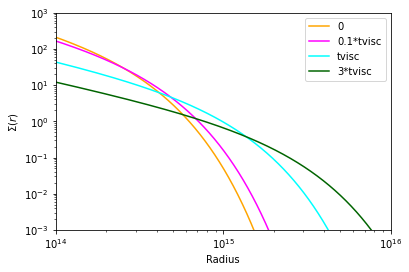

In [27]:
plt.loglog(rad_arr, sig_sim0, c='orange', label='0')
plt.loglog(rad_arr, sig_sim01, c='magenta', label='0.1*tvisc')
plt.loglog(rad_arr, sig_sim1, c='cyan', label='tvisc')
plt.loglog(rad_arr, sig_sim3, c='darkgreen', label='3*tvisc')
plt.legend()
plt.ylabel(r'$\Sigma(r)$')
plt.xlabel('Radius')
plt.xlim(10e13, 10e15)
plt.ylim(10e-4, 10e2)

#### This is how the surface density changes from small to large radius at fixed viscous times.
#### Viscous processes occur over time tvisc (angular momentum distribution transfered due to torquing)
#### at tvisc=0, the surface density falls off quickly with growing radius, but at the extreme end of 3 tviscs the surface density falls off less steeply as a function of radius. This makes sense to me because the more viscous times, the longer the material has to resist flow

In [10]:
delta_t = 1e-3*tvisc # timestep for simulation
t_arr = np.arange(0,5.0*tvisc,delta_t) # array of times
sig_arr = np.zeros((len(t_arr),len(rad_arr))) # array to hold surface density results

In [11]:
# Initial condition
sig_arr[0] = sig_sim(0.0, rad_arr, rscale, sigma0, nu0, gamma)

In [12]:

tstart = time.time() # for tracking how long the integration takes

for i in range(len(t_arr)-1): # loop through array of times
    
    # np.gradient(f,x) returns an array containing df/dx, calculated
    # using a finite difference method (see the main page for details)
    # np.gradient IS GREAT FOR WHEN YOU NEED TO PLOT DERIVATIVES
    
    grad1 = np.gradient(nu(rad_arr)*sig_arr[i]*rad_arr**0.5, rad_arr)
    grad2 = np.gradient(rad_arr**0.5*grad1, rad_arr)
     
    dSigdt = (3./rad_arr)*grad2
    
    sig_arr[i+1] = sig_arr[i] + dSigdt*delta_t
           
    if (i % int((len(t_arr)-1)/10) == 0):
        print ("%i%%" %math.ceil(100*i/(len(t_arr)-1))) # simple progress tracker
    
print("Integration took %.3f seceonds" %(time.time()-tstart)) # print how long integration took

0%


/tmp/ipykernel_135930/3925245442.py:9: RuntimeWarning: overflow encountered in multiply
  grad1 = np.gradient(nu(rad_arr)*sig_arr[i]*rad_arr**0.5, rad_arr)
/home1/07439/moeur/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1092: RuntimeWarning: invalid value encountered in multiply
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]
/home1/07439/moeur/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:1092: RuntimeWarning: invalid value encountered in add
  out[tuple(slice1)] = a * f[tuple(slice2)] + b * f[tuple(slice3)] + c * f[tuple(slice4)]


10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Integration took 7.618 seceonds


#### The integration gives us an array of surface density values which we can plot over our radial range

In [13]:
t_arr.shape

(5000,)

(0.0001, 1000000.0)

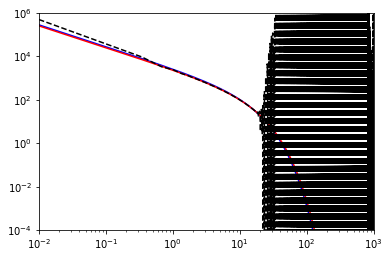

In [14]:
ind =  24

sig_analyt_0 = sig_sim(t_arr[0], rad_arr, rscale, sigma0, nu0, gamma)
sig_analyt = sig_sim(t_arr[ind], rad_arr, rscale, sigma0, nu0, gamma)

plt.loglog(rad_arr/AU, sig_analyt_0, color='blue')
plt.loglog(rad_arr/AU, sig_analyt, color='red')

plt.loglog(rad_arr/AU, sig_arr[ind], color='black', linestyle='dashed')

plt.xlim(0.01,1000)
plt.ylim(1e-4,1e6)

#### at early times, the analytic/self-similar solution of surface density as a fn of radius it appears unstable

(100.0, 1000.0)

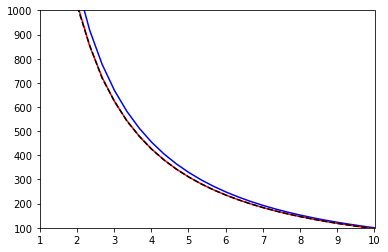

In [15]:
ind = 20 # choose which time index to plot

sig_analyt_0 = sig_sim(t_arr[0], rad_arr, rscale, sigma0, nu0, gamma)
sig_analyt = sig_sim(t_arr[ind], rad_arr, rscale, sigma0, nu0, gamma)

plt.plot(rad_arr/AU, sig_analyt_0, color='blue')
plt.plot(rad_arr/AU, sig_analyt, color='red')

plt.plot(rad_arr/AU, sig_arr[ind], color='black', linestyle='dashed')

plt.xlim(1,10)
plt.ylim(1e2,1e3)

#### yet we have the correct equation

In [31]:
# I made it a class!  The number of times I typed "self" was large.  Is that how
# it's supposed to be, Jules?
class disk_integration:
    """ A class for performing a time integration of the surface density
    of an accretion disk using a BTCS implicit method.
    
    Parameters
    ----------
    r_inner : float, optional
        Inner radius of the disk (cm)
    r_outer: float, optional
        Outer radius of the disk (cm)
    npts : int, optional
        Number of radial points
    r0 : float, optional
        Disk reference radius (cm)
    sigma0 : float, optional
        Surface density normalization (g/cm^2) at radius r0
    T0 : float, optional
        Disk temperature at radius r0 (K)
    alpha : float, optional 
        Parameter for computing viscosity (dimensionless)
    gamma : float, optional
        Powerlaw index for radial dependence of viscosity nu = nu0(r/r0)^gamma
    Mstar : float, optional
        Mass of the central star (g)
    delta_t : int, optional
        Time step of the integration in units of the viscous time at radius r0
    tfinal : float, optional
        Final time for the integration, in units of the viscous time at radius r0
    """
    
    def __init__(self, r_inner=0.01*AU, r_outer=1e3*AU, npts=300, r0=10.0*AU, sigma0=100.0, T0 = 100.0, alpha=1e-3, gamma=1.0, Mstar=Msun, delta_t=1e-3, tfinal=5.0):
        
        # add all the inputs as variables
        self.r_inner = r_inner
        self.r_outer = r_outer
        self.npts = npts
        self.r0 = r0
        self.sigma0 = sigma0
        self.T0 = T0
        self.alpha = alpha
        self.gamma = gamma
        self.Mstar = Mstar
        self.delta_t = delta_t
        self.tfinal = tfinal
    
        # calculate the viscosity normalization at r0
        self.mu = 2.0*mH # mean molecular weight (g)
        self.cs0 = np.sqrt(kB*self.T0/self.mu) # sound speed at r0
        self.Omega = np.sqrt(G*self.Mstar/self.r0**3) # orbital angular frequency at r0
        self.H0 = self.cs0/self.Omega  # scale height of disk at r0
        self.nu0 = self.alpha*self.cs0*self.H0 # kinematic viscosity at r0

        # calculate the viscous time and set up the array of times
        self.tvisc = self.r0**2/self.nu0
        self.delta_t = self.delta_t*self.tvisc # timestep for simulation (s)
        self.tfinal = self.tfinal*self.tvisc # end time for simulation (s)
        self.t_arr = np.arange(0,self.tfinal,self.delta_t) # array of times
        
        # set up the radius array, making it linear in our transformed variable y
        # for nice differencing
        self.y_arr = np.linspace(2*self.r_inner**(1/2),2*self.r_outer**(1/2),num=self.npts)
        self.delta_y = self.y_arr[1]-self.y_arr[0]
        self.rad_arr = (self.y_arr/2.)**2. # array of actual disance from star (cm)

        # set up surface density array in transformed variables
        self.u_arr = np.zeros((len(self.t_arr),len(self.y_arr))) # array to hold transformed surface density
        self.sig_arr = np.zeros(self.u_arr.shape) # array to hold actual surface density (g/cm^2)
        
    def sig_sim(self, t):
        """ Calculate similarity solution for the disk at time t 
        
        Parameters
        ----------
        t : float
            Time (s)
        """ 
        R = self.rad_arr/self.r0 # normalized radius variable
    
        tvisc_mod = self.tvisc / (3*(2-self.gamma)**2) # viscous timescale times an order unity constant
        T = t/tvisc_mod + 1 # time normalized to viscous timescale
        # (see module for discussion of this similarity solution) 
    
        C = self.sigma0*np.exp(1) # normalization coefficient
        sigma = C/R**gamma*T**(-(5./2.-gamma)/(2.-gamma))*np.exp(-R**(2.-gamma)/T)
    
        return sigma
    
    def sig_delta(self):
        """ Generate a gaussian surface density profile at radius r0 that is 
            thin to mimic a delta function. """

        # YOUR FUNCTION HERE
        thin = 0.01 # parameter giving the initial thinness of the gaussian
        
        # standard deviation of the gaussian
        stddev = thin*self.r0/2. # factor of 2 because the standard deviation is half the gaussian width
        
        mean = self.r0 # center of the gaussian
        
        # for approximate comparison, put the same disk mass in a ring with area
        # 2*pi*r0*(thin*r0) that would otherwise be in area pi*r0^2, hence the
        # factor of 2
        sigma = self.sigma0/(thin*2.0)*np.exp(-0.5*((self.rad_arr-mean)/stddev)**2)
        
        return sigma
    
    def set_ic(self, ic_type):
        """ Set up the initial disk surface density profile 
        
        Parameters
        ----------
        ic_type : str
            Type of initial condition.  Options: 'selfsim' = self-similar disk,
            'deltafn' = thin Gaussian approximating a delta function.
        """
        if ic_type == 'selfsim':
            sig_init = self.sig_sim(self.t_arr[0])
        elif ic_type == 'deltafn':
            sig_init = self.sig_delta()
        else:
            raise NotImplementedError(f"I don't have initial conditions for type {ic_type}.")
        
        self.u_arr[0] = sig_init*self.rad_arr**(self.gamma+1/2)
        self.sig_arr[0] = self.u_arr[0]/(self.rad_arr**(self.gamma+1/2)) # we'll transform to actual surface density as we go 
      
        
    def nu(self, r):
        """ Calculate the viscosity at radius r 
        
        Parameters
        ----------
        r : float or array of floats
            Disk radius or radii (cm)
        """
        return self.nu0*(r/self.r0)**self.gamma
    
    def C_i(self, i):
        """ Calculate C_i, defined in the Markdown notes
        
        Parameters
        ----------
        i : int
            Radial position index
        """
        return 12.*self.delta_t/self.delta_y**2.*self.nu(self.rad_arr[i])/self.y_arr[i]**2.
    
   
    def evolve_disk(self):

        # for keeping track of how long the integration takes
        tstart = time.time()

        # In each time step, we'll solve the matrix equation excluding 
        # the two boundary radii, then explicitly adjust the boundaries
        N = len(self.y_arr)-2 # number of radii minus the two boundaries

        # for holding adjustments to the matrix to account for boundary conditions (BCs)
        bc_vec = np.zeros(N)
        
        for j in range(len(self.t_arr)-1): # loop through array of times
        
            # These are for setting up an array for tri-diagonal solving. 
            # In each row of the matrix, b is the value on the diagonal, 
            # a is the value to the left of the diagonal, and
            # c is the value to the right of the diagonal.
            # The vectors a, b, and c are indexed by the matrix row.
            a = np.zeros(N)
            b = np.zeros(N)
            c = np.zeros(N)
    
            # Choose a fixed value D_in for u at the innermost radius.
            # Setting to a fixed value is called a Dirichlet boundary condition.
            D_in = 0.0  # fixed value of u_0
            # We'll add the below to the value of u_1^j (the second radial location)
            # before solving the matrix equation.  Without this, the matrix equation 
            # set up below would be, at the left boundary (where there is no value, a, 
            # to the left of the diagonal because it's the top left corner of the matrix):
            # u_1^j = -C_1 u_2^{j+1} + (1 + 2C_1) u_1^{j+1} but we want
            # u_1^j = -C_1 u_2^{j+1} + (1 + 2C_1) u_1^{j+1} - C_1 u_0^{j+1}
            # We accomplish this by adding C_1 u_0 to u_1^j before solving the matrix
            # equation, so that u_1^j + C_1 u_0 = -C_1 u_2^{j+1} + (1 + 2C_1) u_1^{j+1}
            bc_vec[0] = self.C_i(1)*D_in 
            # At the outer edge of the disk, we'll instead use a zero-derivative boundary
            # condition, which is called a Neumann boundary condition.
            # We'll add the below to the value of u_-2, where like Python indexing, 
            # I'm using -2 as shorthand for npts-2 (so that the index -1 refers to the last
            # element of the array). 
            # The matrix equation without this extra addition would be
            # u_-2^j = (1 + 2C_-2) u_-2^{j+1} - C_-2 u_-3
            # but we want u_-2^j = -C_-2 u_-1^{j+1} + (1 + 2C_-2) u_-2^{j+1} - C_-2 u_-3^{j+1}
            # with u_-1^{j+1} - u_-2^{j+1} = 0, so that u_-2^j = (1 + C_-2) u_-2^{j+1} - C_-2 u_-3^{j+1}
            # We accomplish this by adding C_-2 u_-2^j to u_-2^j before solving the matrix
            # equation, so that u_-2^j + C_-2 u_-2^j = (1 + 2C_-2) u_-2^{j+1} - C_-2 u_-3.
            # It's not exactly perfect since the extra term on the LHS has u_-2^j instead
            # of u_-2^{j+1}, but it does the job.
            bc_vec[-1] = self.C_i(-2)*self.u_arr[j][-2] 
            
            for i in range(N): 
            
                # Set up and solve the matrix equation.
                # (If this were an explicit scheme we'd loop through u_arr 
                # and set the values of u[j+1] explicitly.)
        
                Ci = self.C_i(i)
        
                if i == 0: # a[0] is undefined
                    b[0] = 1+2*Ci
                    c[0] = -Ci
                elif i == N - 1: # c[-1] is undefined
                    a[-1] = -Ci
                    b[-1] = 1+2*Ci
                else:
                    a[i] = -Ci
                    b[i] = 1+2*Ci
                    c[i] = -Ci
                    
            sol = solve_tri_diag(a,b,c,self.u_arr[j][1:-1]+bc_vec)
    
            #u at next timestep is the solution with the inner and outer BCs added
            self.u_arr[j+1] = np.concatenate(([D_in],sol,[sol[-1]])) 
        
            self.sig_arr[j+1] = self.u_arr[j+1]/(self.rad_arr**(self.gamma+1/2)) # convert from u to actual surface density
            
            if (j % int((len(self.t_arr)-1)/10) == 0):
                print ("%i%%" %math.ceil(100*j/(len(self.t_arr)-1))) # rudimentary progress tracker
    
        print("Integration took %.3f seceonds" %(time.time()-tstart)) # print how long integration took

In [32]:
# set up the disk
disk = disk_integration()
# set the initial condition
disk.set_ic('selfsim')
# run the simulation
disk.evolve_disk()

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Integration took 43.835 seceonds


(0.0001, 1000000.0)

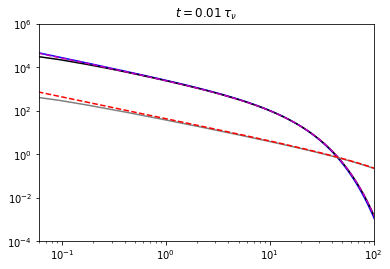

In [33]:
ind = 10


plt.loglog(disk.rad_arr/AU,disk.sig_arr[0], 'b') # initial disk structure

plt.loglog(disk.rad_arr/AU,disk.sig_arr[ind], 'k') # numerical result
plt.loglog(disk.rad_arr/AU, disk.sig_sim(disk.t_arr[ind]), 'm--') # analytic result for comparison

plt.loglog(disk.rad_arr/AU,disk.sig_arr[-1], color='gray') # numerical result at the end of the integration
plt.loglog(disk.rad_arr/AU, disk.sig_sim(disk.t_arr[-1]), 'r--') # analytic result for comparison at the end of the integration

plt.title(r"$t = %.2f \, \tau_\nu$" %(disk.t_arr[ind]/disk.tvisc)) # the r makes this a raw string

plt.xlim(6e-2,100)
plt.ylim(1e-4,1e6)

#### The result after using our utility to solve the tri-diagonal matrix for surface denstiy values as a function of radius at fixed small tvisc

#### The integrated result does not have a steep falloff at large tvisc but i'm not sure why this is or if we should expect such a gradual and small falloff of the surface density at large radius. I should think it would be *way* less dense that far out.

#### Wait i think it's because tvisc is so small?

In [34]:
# set up the disk
disk = disk_integration()
# set the initial condition
disk.set_ic('deltafn')
# run the simulation
disk.evolve_disk()

0%
10%
20%
30%
40%
50%
60%
70%
80%
90%
100%
Integration took 43.685 seceonds


(0.0001, 1000000.0)

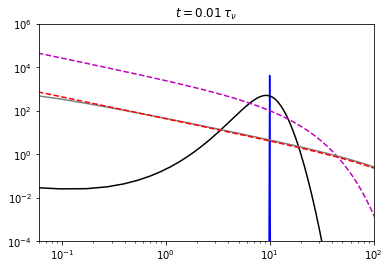

In [35]:
ind = 10

plt.loglog(disk.rad_arr/AU,disk.sig_arr[0], 'b') # initial disk structure

plt.loglog(disk.rad_arr/AU,disk.sig_arr[ind], 'k') # numerical result
plt.loglog(disk.rad_arr/AU, disk.sig_sim(disk.t_arr[ind]), 'm--') # analytic result for comparison

plt.loglog(disk.rad_arr/AU,disk.sig_arr[-1], color='gray') # numerical result
plt.loglog(disk.rad_arr/AU, disk.sig_sim(disk.t_arr[-1]), 'r--') # analytic result for comparison

plt.title(r"$t = %.2f \, \tau_\nu$" %(disk.t_arr[ind]/disk.tvisc)) # the r makes this a raw string

plt.xlim(6e-2,100)
plt.ylim(1e-4,1e6)

#### Blue is our 'delta function' and these surface density values are normalized

(0.0001, 1000000.0)

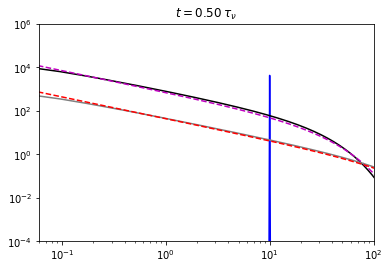

In [36]:
ind = 500

plt.loglog(disk.rad_arr/AU,disk.sig_arr[0], 'b') # initial disk structure

plt.loglog(disk.rad_arr/AU,disk.sig_arr[ind], 'k') # numerical result
plt.loglog(disk.rad_arr/AU, disk.sig_sim(disk.t_arr[ind]), 'm--') # analytic result for comparison

plt.loglog(disk.rad_arr/AU,disk.sig_arr[-1], color='gray') # numerical result
plt.loglog(disk.rad_arr/AU, disk.sig_sim(disk.t_arr[-1]), 'r--') # analytic result for comparison

plt.title(r"$t = %.2f \, \tau_\nu$" %(disk.t_arr[ind]/disk.tvisc)) # the r makes this a raw string

plt.xlim(6e-2,100)
plt.ylim(1e-4,1e6)

#### The numerical results match the analytic results very well (at half tvisc)!